The following section is separated in two parts. First, we extract and visualize in a map the Unemployement rate for swiss nationality holders and foreigners. The visualization is followed by textual analyses on the meaning of the statistics. The second part, categorize the unemployement rate to diffent age group and it follows an analyse.


### First Part

In [162]:
# Import the usefull libraries.
import pandas as pd
import numpy as np
import folium # to generate the map.
from folium import plugins
import json # manipulate json files.
import matplotlib # plot bar plots
import matplotlib.pyplot as plt

The unemployement rate is found in the officiel website of the confederation <a href="https://www.amstat.ch/v2/index.jsp" target="_blank"> amstat</a> . Using there extrating interface, we download a csv file which contains the unemployement rate for foreigners and swiss nationality holder per canton.

In [163]:
data_filename = r'data/unemployement_rate_foreign_modif.csv'
data = pd.read_csv(data_filename, skiprows = 2) # skip the first to lines.
data.tail()

,Canton,Nationalité,Mois,Septembre 2017,Septembre 2017.1,Septembre 2017.2,Septembre 2017.3,Total,Total.1,Total.2,Total.3
49,Genève,Etrangers,NaN,5.7,A,5'942,7'601,5.7,A,5'942,7'601
50,Genève,Suisses,NaN,4.8,A,6'292,7'896,4.8,A,6'292,7'896
51,Jura,Etrangers,NaN,9,C,505,729,9,C,505,729
52,Jura,Suisses,NaN,3.6,B,1'114,1'646,3.6,B,1'114,1'646
53,Total,NaN,NaN,3,A,133'169,193'624,3,A,133'169,193'624


As you can see, the row is not relevent as we want to show the pourcentage per canton, we keep the necesary columns ( Canton, Nationalité,Septembre 2017). Septembre 2017 respresent the unemployement rate.

In [164]:
# drop the unused column.
keep_index = ['Canton', 'Nationalité','Septembre 2017']
data_dropped =data[keep_index]
data_dropped = data_dropped.drop([0,53]) # the first line is also not relevent.because it is a line of separation.
data_dropped.head()

,Canton,Nationalité,Septembre 2017
1,Zurich,Etrangers,5.3
2,Zurich,Suisses,2.5
3,Berne,Etrangers,5.5
4,Berne,Suisses,1.8
5,Lucerne,Etrangers,3.9


The idea is two have 1 dataframe for each group, swiss nationality horlders and foreigners. Let's start with the Swiss.

In [165]:
swiss_data = data_dropped[data_dropped.Nationalité == 'Suisses'] ## filter by Swiss.
swiss_data = swiss_data.drop('Nationalité',axis=1)
swiss_data['Septembre 2017'] = swiss_data['Septembre 2017'].astype(float)
swiss_data.head()


,Canton,Septembre 2017
2,Zurich,2.5
4,Berne,1.8
6,Lucerne,1.3
8,Uri,0.4
10,Schwyz,1.2


We do the same with the foreigners.

In [167]:
foreign_data = data_dropped[data_dropped.Nationalité == 'Etrangers']
foreign_data = foreign_data.drop('Nationalité',axis=1)
foreign_data['Septembre 2017'] = foreign_data['Septembre 2017'].astype(float)
foreign_data.head()

,Canton,Septembre 2017
1,Zurich,5.3
3,Berne,5.5
5,Lucerne,3.9
7,Uri,2.1
9,Schwyz,3.4


To create the map, We need to attach each canton his percentage. By inspecting the json file ( `ch-cantons.topojson.json` ) we see in each canton entity, there is a `name` and `id` field. The id field represent the officiel abbreviation , BE for Berne for example. 

In order to link the percentage with the cantons, one idea is to link with the `name` field. This is a bad idea because they are not always the same. The right idea is to link with the `id`. Our Dataframe as no `id` field, therefore we will use the json to extract the id field and concatenate with our dataframe. Fortunaly, the order of the canton appearance in the id field and our dataframe is the same.

In [168]:
json_filename = r'topojson/ch-cantons.topojson.json' 
canton_data = json.load(open(json_filename))

id_canton = pd.DataFrame(canton_data['objects']['cantons']['geometries'])['id']
swiss_data = swiss_data.reset_index()
swiss_data = swiss_data.drop('index', axis =1)


foreign_data = foreign_data.reset_index()
foreign_data = foreign_data.drop('index', axis =1)



In [169]:
swiss_data = swiss_data.join(id_canton)
swiss_data.head()


,Canton,Septembre 2017,id
0,Zurich,2.5,ZH
1,Berne,1.8,BE
2,Lucerne,1.3,LU
3,Uri,0.4,UR
4,Schwyz,1.2,SZ


In [170]:
foreign_data = foreign_data.join(id_canton)
foreign_data.head()

,Canton,Septembre 2017,id
0,Zurich,5.3,ZH
1,Berne,5.5,BE
2,Lucerne,3.9,LU
3,Uri,2.1,UR
4,Schwyz,3.4,SZ


In [172]:
foreign_data = foreign_data[['id','Septembre 2017']] 
foreign_data
swiss_data = swiss_data[['id','Septembre 2017']] 

We have all we need to diplay the map. We create a function `build_map(data,column,title)` that diplay the map linked with the data. (see doc)

In [173]:
# This function return a folium map with the data linked to it.
# data: the data to attach
# column : the index of the column, first the id and the sequence is the percentage.
# title : The name of the map.
def build_map(data,column,title):
    m = folium.Map([46.8182,8.2275], tiles='cartodbpositron', zoom_start = 7)
   
    
    m.choropleth(geo_data=canton_data, data=data,
             columns=column,topojson = 'objects.cantons',
             key_on='feature.id',
             fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.2,
             legend_name=title, highlight = True)
    return m

In [174]:
m_swiss = build_map(swiss_data, ['id', 'Septembre 2017'], 'Unemployement rate for swiss nationality holders (%)')
m_swiss

In [175]:
m_foreign = build_map(foreign_data, ['id', 'Septembre 2017'], 'Unemployement rate for foreigners (%)')
m_foreign

Now that we showed the unemployement rate and swiss nationality holder and foreigners, lets see the differences between them. We first merge them together in order to take the difference.

In [176]:

merge_data = swiss_data.merge(foreign_data,on='id')
merge_data.columns = ['id','swiss','foreign']
merge_data.head()


,id,swiss,foreign
0,ZH,2.5,5.3
1,BE,1.8,5.5
2,LU,1.3,3.9
3,UR,0.4,2.1
4,SZ,1.2,3.4


We take the difference.

In [177]:
merge_data['diff'] = merge_data['foreign']/merge_data['swiss']
merge_data.head()

,id,swiss,foreign,diff
0,ZH,2.5,5.3,2.120000
1,BE,1.8,5.5,3.055556
2,LU,1.3,3.9,3.000000
3,UR,0.4,2.1,5.250000
4,SZ,1.2,3.4,2.833333


Display the map using the function created above.

In [179]:
m_diff = build_map(merge_data, ['id','diff'], 'Ratio Difference between the swiss and foreigners.')
m_diff


Above, the ratio between the umployement rate between the swiss nationality and foreigners, we see that the center of the country (<a href="https://en.wikipedia.org/wiki/Canton_of_Waldst%C3%A4tten" target="_blank">Waldstätten</a>) has a large disparency. It is because, this cantons have conservative tendency, therefore it is more difficult to find a job for foreigners.

### Second Part

Ad the first part, we will extract the data from the confederation website and make a bar plot where the x axes represent the cantons and the y the percentage of unemployement.

In [180]:
data = pd.read_csv('./data/unemployement_rateAge.csv')
data.head()

,Canton,Age Class,Unemployement rate
0,Zurich,15-24 ans,3.7
1,Zurich,25-49 ans,3.4
2,Zurich,50 ans et plus,2.9
3,Berne,15-24 ans,2.8
4,Berne,25-49 ans,2.5


 We are able to plot the bar plot.

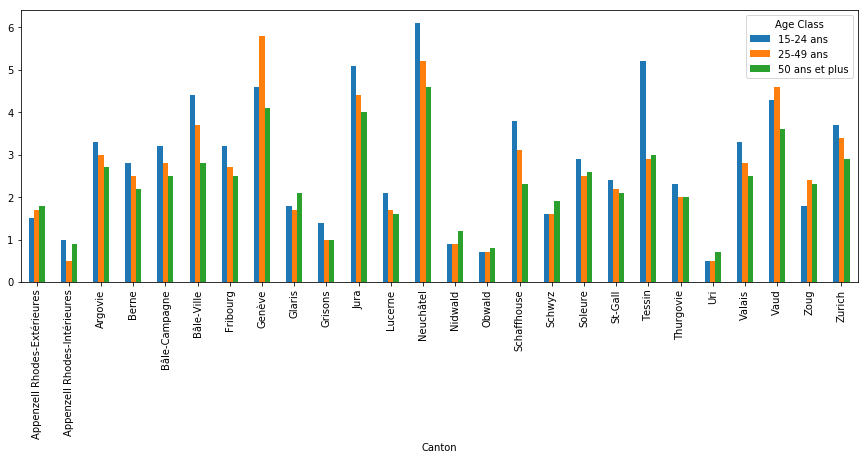

In [181]:
pivot = data.pivot(index = 'Canton', columns='Age Class', values='Unemployement rate')
pivot.plot.bar(figsize = (15,5))
plt.show()



Some values are interessing to note. Geneva has a high percentage of unemployement rate for age class 25-49 and Ticino has a high percentage for age group between 15-24. They both are border cantons. In the border, there is a high traffic of people that comes from behond the border to work, because the salary is high. For the employee it is cheaper therefore the work market is saturated.
